In [7]:
# Colab-ready: memmap + DataLoader + VAE training (Option 1)
# Paste and run this cell in Colab. Adjust NPZ_PATH if needed.

import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import time

# 1) Path to your .npz file in Drive (edit if necessary)
NPZ_PATH = '/content/drive/MyDrive/dsprites_ndarray_co1sh3sc6or40x32y32_64x64.npz'
assert os.path.exists(NPZ_PATH), f"File not found: {NPZ_PATH}. Upload or change path."

# 2) Memory-map the .npz archive (imgs will be memmap-like and not fully loaded)
npz = np.load(NPZ_PATH, mmap_mode='r', allow_pickle=True)
imgs = npz['imgs']   # shape (N, 64, 64) typically, memmap-like
print('imgs shape, dtype:', imgs.shape, imgs.dtype)

# 3) PyTorch Dataset that reads single images on demand from memmap
class DspritesMemmapDataset(Dataset):
    # Pass factors data during initialization
    def __init__(self, memmap_imgs, memmap_factors):
        self.memmap_imgs = memmap_imgs
        self.memmap_factors = memmap_factors # Store factor data

    def __len__(self):
        # Ensure lengths are consistent
        return len(self.memmap_imgs)

    def __getitem__(self, idx):
        idx = int(idx)

        # --- Image Processing ---
        img = np.asarray(self.memmap_imgs[idx], dtype=np.float32)
        if img.max() > 1.0:
            img = img / 255.0
        if img.ndim == 2:
            img = img[None, ...]

        t_img = torch.from_numpy(img)
        if USE_FLOAT16_ON_HOST:
            t_img = t_img.to(dtype=torch.float16)
        else:
            t_img = t_img.to(dtype=torch.float32)

        # --- Factor Processing ---
        # Read the corresponding factor vector
        factors = np.asarray(self.memmap_factors[idx], dtype=np.float32)
        t_factors = torch.from_numpy(factors).to(dtype=torch.float32)

        # CRITICAL: Return the Image and the Factor vector
        return t_img, t_factors


# 4) Device and hyperparameters (tweak as required)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

BATCH_SIZE = 128           # increase if GPU can handle it (was 64)
NUM_WORKERS = 2            # number of DataLoader worker processes (was 2)
PREFETCH_FACTOR = 8        # per-worker number of batches to prefetch (default=2)
PERSISTENT_WORKERS = True  # keep workers alive between epochs
USE_FLOAT16_ON_HOST = False # workers will return float16 tensors to reduce host RAM

PIN_MEMORY = True if device.type == 'cuda' else False

LATENT_DIM = 10
EPOCHS = 50               # reduce for testing
INITIAL_LR = 1e-3
BETA = 1.0

# optional: speed up cuDNN convs for fixed-size inputs
torch.backends.cudnn.benchmark = True


# 5) DataLoader for the entire dataset with shuffle=True (each epoch sees all samples)
dataset = DspritesMemmapDataset(imgs, npz['latents_values'])
train_loader = DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
    prefetch_factor=PREFETCH_FACTOR,
    persistent_workers=PERSISTENT_WORKERS
)

# 6) VAE model (kept similar to your architecture)
class VAE(nn.Module):
    def __init__(self, latent_dim=10):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder_conv = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1), # 64 -> 32
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1), # 32 -> 16
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1), # 16 -> 8
            nn.ReLU(),
        )
        self.fc_mu = nn.Linear(128 * 8 * 8, latent_dim)
        self.fc_logvar = nn.Linear(128 * 8 * 8, latent_dim)
        self.fc_decoder = nn.Linear(latent_dim, 128 * 8 * 8)
        self.decoder_deconv = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1), # 8 -> 16
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # 16 -> 32
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),   # 32 -> 64
            nn.Sigmoid()
        )

    def encode(self, x):
        h = self.encoder_conv(x)
        h = h.view(h.size(0), -1)
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = self.fc_decoder(z)
        h = h.view(h.size(0), 128, 8, 8)
        return self.decoder_deconv(h)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# Replace your existing vae_loss_function with this standard, batch-normalized version
def vae_loss_function_standard(recon_x, x, mu, logvar, beta=1.0):
    # --- Reconstruction Loss (BCE) ---
    # Sum over pixels (dimensions 1, 2, 3), then mean over the batch (dimension 0)
    # This gives the average BCE loss per sample.
    BCE = nn.functional.binary_cross_entropy(recon_x, x, reduction='none').sum(dim=[1, 2, 3]).mean()

    # --- KL Divergence Loss (KLD) ---
    # Sum over latent dimensions (dim=1), then mean over the batch (dimension 0)
    KLD_per_sample = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1)
    KLD = beta * torch.mean(KLD_per_sample)

    # Total loss is the sum of the two terms (averaged per sample)
    return BCE + KLD, BCE, KLD

# 7) Initialize model and optimizer
model = VAE(latent_dim=LATENT_DIM).to(device)
optimizer = optim.Adam(model.parameters(), lr=INITIAL_LR)

# 8) Training loop (on-disk reads; safe on RAM)


imgs shape, dtype: (737280, 64, 64) uint8
Using device: cuda


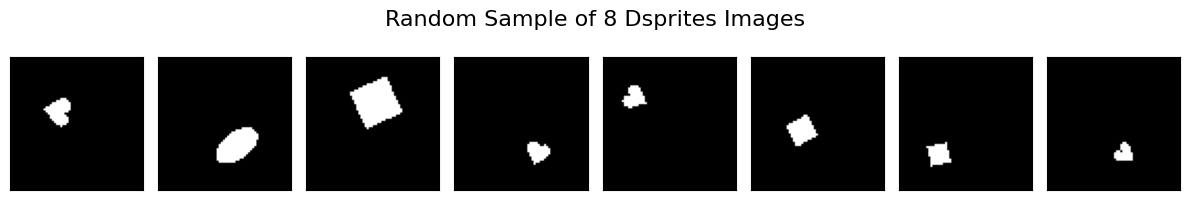

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def display_dsprites_samples(imgs, num_samples=8):
    """Selects and displays a grid of dsprites images."""

    # Check if a channel dimension exists (N, C, H, W)
    if len(imgs.shape) == 4 and imgs.shape[1] == 1:
        img_data = imgs[:, 0, :, :]
    else:
        # Assume shape (N, H, W)
        img_data = imgs

    num_total = img_data.shape[0]
    if num_total < num_samples:
        num_samples = num_total

    # 1. Select random indices
    idxs = np.random.choice(num_total, num_samples, replace=False)

    # 2. Setup grid visualization
    fig, axes = plt.subplots(1, num_samples, figsize=(1.5 * num_samples, 2))

    for i, idx in enumerate(idxs):
        image = img_data[idx]

        # Normalize and display (assuming data is 0-255 or already normalized to 0-1)
        axes[i].imshow(image, cmap='gray')

        axes[i].set_xticks([])
        axes[i].set_yticks([])

    fig.suptitle(f"Random Sample of {num_samples} Dsprites Images", fontsize=16)
    plt.tight_layout()
    plt.show() # In a local environment, use plt.show()

display_dsprites_samples(imgs, num_samples=8)

In [4]:
import os
import torch

def save_checkpoint(save_dir, model, optimizer, epoch,
                    beta=1, scheduler=None, scaler=None,
                    history=None, prefix="vae"):
    os.makedirs(save_dir, exist_ok=True)
    ckpt = {
        'epoch': epoch,
        'model_state': model.state_dict(),
        'optimizer_state': optimizer.state_dict(),
    }
    if scheduler is not None:
        ckpt['scheduler_state'] = scheduler.state_dict()
    if scaler is not None:
        ckpt['scaler_state'] = scaler.state_dict()
    if history is not None:
        ckpt['history'] = history  # e.g. dict of lists

    path = os.path.join(save_dir, f"{prefix}_epoch_{epoch}_beta_{beta}.pth")
    torch.save(ckpt, path)
    print(f"Saved checkpoint: {path}")
    return path


In [ ]:
import glob
import re

def find_latest_checkpoint(dirpath, prefix="vae"):
    files = glob.glob(os.path.join(dirpath, f"{prefix}_epoch_*.pth"))
    if not files:
        return None
    # extract epoch numbers and pick the largest
    def epoch_from_name(fn):
        m = re.search(rf"{prefix}_epoch_(\d+)\.pth", os.path.basename(fn))
        return int(m.group(1)) if m else -1
    latest = max(files, key=epoch_from_name)
    return latest

# ----- usage -----
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VAE(latent_dim=LATENT_DIM).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=INITIAL_LR)
if 'lr_scheduler' in globals(): lr_scheduler = ...
# if using AMP
# scaler = torch.cuda.amp.GradScaler()

ckpt_path = find_latest_checkpoint("/content/drive/MyDrive", prefix="vae")
if ckpt_path is not None:
    print("Loading checkpoint:", ckpt_path)
    ckpt = torch.load(ckpt_path, map_location=DEVICE)
    model.load_state_dict(ckpt['model_state'])
    optimizer.load_state_dict(ckpt['optimizer_state'])
    start_epoch = ckpt.get('epoch', 0) + 1
    if 'scheduler_state' in ckpt and 'lr_scheduler' in globals():
        lr_scheduler.load_state_dict(ckpt['scheduler_state'])
    if 'scaler_state' in ckpt and 'scaler' in globals():
        scaler.load_state_dict(ckpt['scaler_state'])
    history = ckpt.get('history', None)
    if history is not None:
        history_total_loss = history.get('total_loss', [])
        history_bce_loss = history.get('bce', [])
        history_kld_loss = history.get('kld', [])
    print(f"Resuming from epoch {start_epoch}")
else:
    print("No checkpoint found, starting from epoch 1")
    start_epoch = 1


In [5]:
def show_images_grid(imgs_, num_images=25):
    # This utility is kept for the final evaluation
    ncols = int(np.ceil(num_images**0.5))
    nrows = int(np.ceil(num_images / ncols))
    _, axes = plt.subplots(nrows, ncols, figsize=(nrows * 3, ncols * 3))
    axes = axes.flatten()

    for ax_i, ax in enumerate(axes):
        if ax_i < num_images:
            # Ensure the image is a numpy array for matplotlib
            if isinstance(imgs_[ax_i], torch.Tensor):
                img = imgs_[ax_i].cpu().numpy().squeeze()
            else:
                img = imgs_[ax_i].squeeze()
            ax.imshow(img, cmap='Greys_r', interpolation='nearest')
            ax.set_xticks([])
            ax.set_yticks([])
        else:
            ax.axis('off')
    plt.show()


In [ ]:
BETA = 1.0
history_total_loss = []
history_bce_loss = []
history_kld_loss = []

start_time = time.time()
for epoch in range(1, EPOCHS + 1):
    model.train()
    train_loss = 0.0
    train_bce = 0.0
    train_kld = 0.0
    batch_start_time = time.time()

    for batch_idx, data in enumerate(train_loader):
        # data shape: (B, 1, 64, 64)
        data = data.to(device, non_blocking=PIN_MEMORY).float()
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss, bce, kld = vae_loss_function(recon_batch, data, mu, logvar, beta=BETA)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_bce += bce.item()
        train_kld += kld.item()

    avg_loss = train_loss / len(train_loader.dataset)
    avg_bce = train_bce / len(train_loader.dataset)
    avg_kld = train_kld / len(train_loader.dataset)

    history_total_loss.append(avg_loss)
    history_bce_loss.append(avg_bce)
    history_kld_loss.append(avg_kld)

    epoch_time = time.time() - batch_start_time
    print(f"Epoch {epoch:02d}/{EPOCHS}  Avg Loss: {avg_loss:.4f}  BCE: {avg_bce:.4f}  KLD: {avg_kld:.4f}  time: {epoch_time:.1f}s")

    # ✅ Save model every 10 epochs
    if epoch % 10 == 0:
      history = {
          'total_loss': history_total_loss,
          'bce': history_bce_loss,
          'kld': history_kld_loss
      }
      save_checkpoint("/content/drive/MyDrive",
                      model, optimizer, epoch, beta=BETA,
                      scheduler=lr_scheduler if 'lr_scheduler' in globals() else None,
                      scaler=scaler if 'scaler' in globals() else None,
                      history=history,
                      prefix="vae")

total_time = time.time() - start_time
print(f"Training finished in {total_time/60:.2f} minutes.")

# Save final model too (optional)
final_save_path = f'/content/drive/MyDrive/vae_final_beta_{BETA}.pth'
torch.save(model.state_dict(), final_save_path)
print("Final model saved to:", final_save_path)


Epoch 01/50  Avg Loss: 99.9950  BCE: 74.4060  KLD: 25.5890  time: 75.2s
Epoch 02/50  Avg Loss: 63.7381  BCE: 36.6774  KLD: 27.0607  time: 72.8s
Epoch 03/50  Avg Loss: 59.9940  BCE: 32.5513  KLD: 27.4427  time: 72.4s
Epoch 04/50  Avg Loss: 56.7917  BCE: 28.8586  KLD: 27.9330  time: 72.2s
Epoch 05/50  Avg Loss: 53.9602  BCE: 25.5212  KLD: 28.4390  time: 72.1s
Epoch 06/50  Avg Loss: 52.0965  BCE: 23.4090  KLD: 28.6874  time: 72.0s
Epoch 07/50  Avg Loss: 50.8661  BCE: 22.0550  KLD: 28.8110  time: 72.0s
Epoch 08/50  Avg Loss: 50.0068  BCE: 21.1596  KLD: 28.8472  time: 71.9s
Epoch 09/50  Avg Loss: 49.3257  BCE: 20.4806  KLD: 28.8451  time: 71.9s
Epoch 10/50  Avg Loss: 48.8117  BCE: 19.9823  KLD: 28.8293  time: 71.8s
✅ Saved model at epoch 10 to /content/drive/MyDrive/vae_epoch_10_Beta_1.0.pth
Epoch 11/50  Avg Loss: 48.3680  BCE: 19.5653  KLD: 28.8027  time: 72.1s
Epoch 12/50  Avg Loss: 48.0023  BCE: 19.2310  KLD: 28.7713  time: 72.0s
Epoch 13/50  Avg Loss: 47.6874  BCE: 18.9589  KLD: 28.7285

<>:15: SyntaxWarning: invalid escape sequence '\m'
<>:15: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipython-input-3768007171.py:15: SyntaxWarning: invalid escape sequence '\m'
  plt.plot(history_bce_loss, label='Reconstruction Loss ($\mathcal{L}$)')



Plotting Loss History...


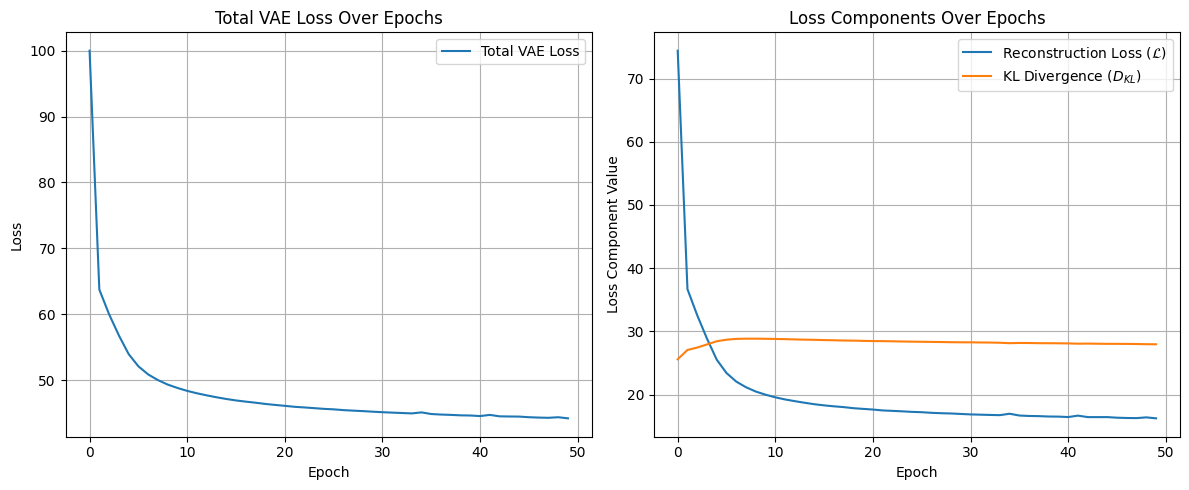


Displaying 8 original images and their reconstructions.
Format: [Original | Reconstructed | Original | Reconstructed | ...]


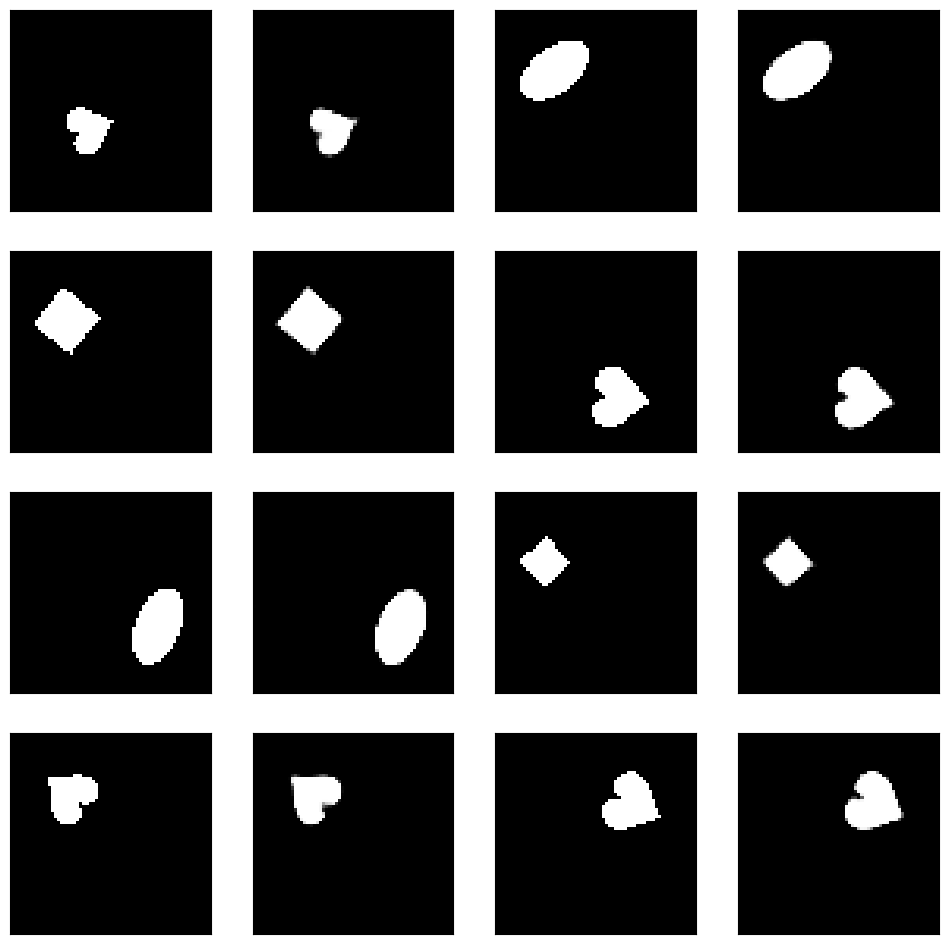

In [ ]:
print("\nPlotting Loss History...")
plt.figure(figsize=(12, 5))

# Plot Total Loss
plt.subplot(1, 2, 1)
plt.plot(history_total_loss, label='Total VAE Loss')
plt.title('Total VAE Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

# Plot Loss Components
plt.subplot(1, 2, 2)
plt.plot(history_bce_loss, label='Reconstruction Loss ($\mathcal{L}$)')
plt.plot(history_kld_loss, label='KL Divergence ($D_{KL}$)')
plt.title('Loss Components Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss Component Value')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

## Original vs. Reconstructed Images Comparison

# Select 8 random images (Original vs. Reconstructed)
model.eval()
NUM_SAMPLES = 8
random_indices = np.random.choice(len(data), NUM_SAMPLES, replace=False)
sample_images = data[random_indices].to(device)

with torch.no_grad():
    reconstructed_images, _, _ = model(sample_images)

# Prepare images for display:
# Combine original and reconstructed: [Original_1, Reconstructed_1, Original_2, Reconstructed_2, ...]
display_images = []
for i in range(NUM_SAMPLES):
    display_images.append(sample_images[i].cpu())
    display_images.append(reconstructed_images[i].cpu())

print(f"\nDisplaying {NUM_SAMPLES} original images and their reconstructions.")
print("Format: [Original | Reconstructed | Original | Reconstructed | ...]")

# Display 2*NUM_SAMPLES images (8 original + 8 reconstructed = 16 images)
show_images_grid(display_images, num_images=2 * NUM_SAMPLES)

<>:30: SyntaxWarning: invalid escape sequence '\m'
<>:30: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipython-input-1346555442.py:30: SyntaxWarning: invalid escape sequence '\m'
  plt.plot(history_bce_loss, label='Reconstruction Loss ($\mathcal{L}$)')


Starting training on device: cuda
Epoch: 1 | Avg Total Loss: 169.7895 | Avg BCE: 110.7455 | Avg KLD: 59.0440
Epoch: 2 | Avg Total Loss: 143.5791 | Avg BCE: 80.0794 | Avg KLD: 63.4997
Epoch: 3 | Avg Total Loss: 138.8067 | Avg BCE: 73.6443 | Avg KLD: 65.1624
Epoch: 4 | Avg Total Loss: 136.1514 | Avg BCE: 70.3394 | Avg KLD: 65.8121
Epoch: 5 | Avg Total Loss: 134.4478 | Avg BCE: 68.4157 | Avg KLD: 66.0321
Epoch: 6 | Avg Total Loss: 133.1953 | Avg BCE: 66.9637 | Avg KLD: 66.2315
Epoch: 7 | Avg Total Loss: 132.1123 | Avg BCE: 65.8794 | Avg KLD: 66.2329
Epoch: 8 | Avg Total Loss: 131.3874 | Avg BCE: 65.0366 | Avg KLD: 66.3508
Epoch: 9 | Avg Total Loss: 130.7104 | Avg BCE: 64.2779 | Avg KLD: 66.4325
Epoch: 10 | Avg Total Loss: 130.0821 | Avg BCE: 63.5748 | Avg KLD: 66.5072
Epoch: 11 | Avg Total Loss: 129.5357 | Avg BCE: 62.9782 | Avg KLD: 66.5574
Epoch: 12 | Avg Total Loss: 129.0795 | Avg BCE: 62.5120 | Avg KLD: 66.5674
Epoch: 13 | Avg Total Loss: 128.6900 | Avg BCE: 62.0335 | Avg KLD: 66.6565

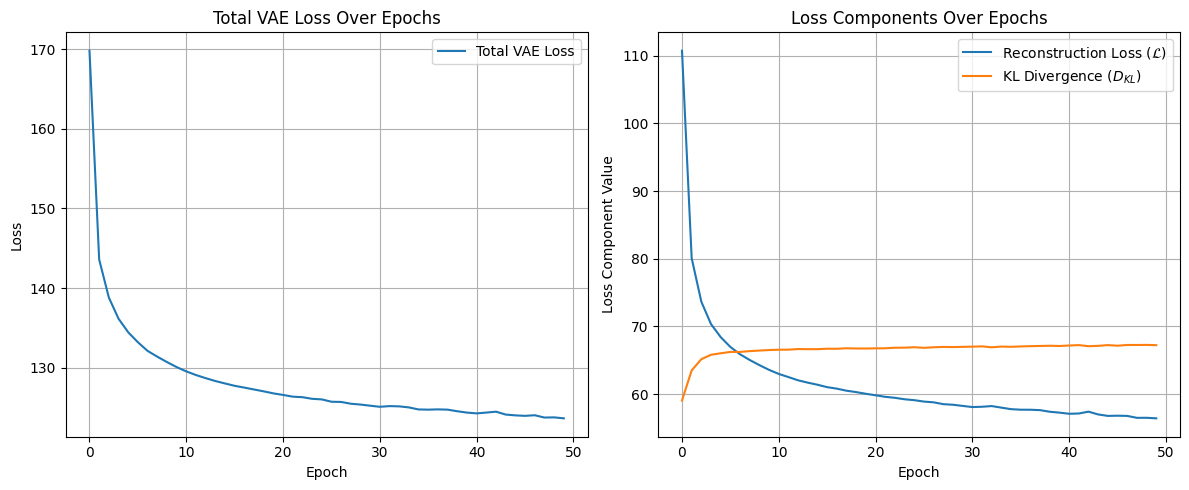


Displaying 8 original images and their reconstructions.
Format: [Original | Reconstructed | Original | Reconstructed | ...]


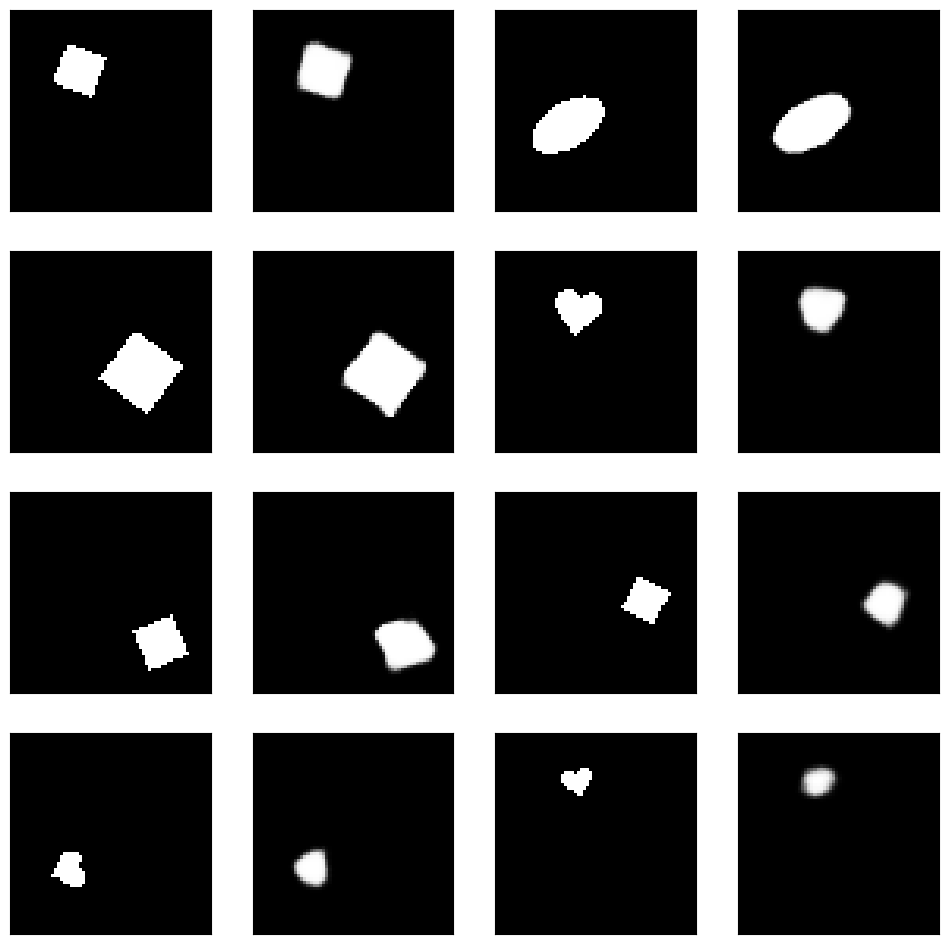

In [ ]:
#TRAINED WITHOUT SAVING CHECKPOINTS!

BATCH_SIZE = 32 # A common choice for VAEs
LATENT_DIM = 10 # A common choice, the table uses 'h_dim', let's set it to 10
EPOCHS = 50
INITIAL_LR = 0.001
BETA = 5

print(f"Starting training on device: {device}")
for epoch in range(1, EPOCHS + 1):
    train(epoch, BETA)
print("Training complete.")

# --- 8. Evaluation and Plotting (As requested) ---

## Loss History Plot 📈

print("\nPlotting Loss History...")
plt.figure(figsize=(12, 5))

# Plot Total Loss
plt.subplot(1, 2, 1)
plt.plot(history_total_loss, label='Total VAE Loss')
plt.title('Total VAE Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

# Plot Loss Components
plt.subplot(1, 2, 2)
plt.plot(history_bce_loss, label='Reconstruction Loss ($\mathcal{L}$)')
plt.plot(history_kld_loss, label='KL Divergence ($D_{KL}$)')
plt.title('Loss Components Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss Component Value')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

## Original vs. Reconstructed Images Comparison

# Select 8 random images (Original vs. Reconstructed)
model.eval()
NUM_SAMPLES = 8
random_indices = np.random.choice(len(dataset), NUM_SAMPLES, replace=False)
sample_images = dataset[random_indices].to(device)

with torch.no_grad():
    reconstructed_images, _, _ = model(sample_images)

# Prepare images for display:
# Combine original and reconstructed: [Original_1, Reconstructed_1, Original_2, Reconstructed_2, ...]
display_images = []
for i in range(NUM_SAMPLES):
    display_images.append(sample_images[i].cpu())
    display_images.append(reconstructed_images[i].cpu())

print(f"\nDisplaying {NUM_SAMPLES} original images and their reconstructions.")
print("Format: [Original | Reconstructed | Original | Reconstructed | ...]")

# Display 2*NUM_SAMPLES images (8 original + 8 reconstructed = 16 images)
show_images_grid(display_images, num_images=2 * NUM_SAMPLES)

<>:30: SyntaxWarning: invalid escape sequence '\m'
<>:30: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipython-input-2831397053.py:30: SyntaxWarning: invalid escape sequence '\m'
  plt.plot(history_bce_loss, label='Reconstruction Loss ($\mathcal{L}$)')


Starting training on device: cuda
Epoch: 1 | Avg Total Loss: 303.8718 | Avg BCE: 182.1181 | Avg KLD: 121.7536
Epoch: 2 | Avg Total Loss: 280.9773 | Avg BCE: 154.9429 | Avg KLD: 126.0344
Epoch: 3 | Avg Total Loss: 278.2614 | Avg BCE: 152.4684 | Avg KLD: 125.7930
Epoch: 4 | Avg Total Loss: 276.5854 | Avg BCE: 151.2255 | Avg KLD: 125.3598
Epoch: 5 | Avg Total Loss: 275.3658 | Avg BCE: 150.4211 | Avg KLD: 124.9447
Epoch: 6 | Avg Total Loss: 274.3780 | Avg BCE: 149.8192 | Avg KLD: 124.5588
Epoch: 7 | Avg Total Loss: 273.7173 | Avg BCE: 149.3132 | Avg KLD: 124.4041
Epoch: 8 | Avg Total Loss: 273.4903 | Avg BCE: 148.8344 | Avg KLD: 124.6560
Epoch: 9 | Avg Total Loss: 273.2746 | Avg BCE: 148.5714 | Avg KLD: 124.7033
Epoch: 10 | Avg Total Loss: 273.0258 | Avg BCE: 148.2247 | Avg KLD: 124.8011
Epoch: 11 | Avg Total Loss: 272.7058 | Avg BCE: 148.1154 | Avg KLD: 124.5904
Epoch: 12 | Avg Total Loss: 272.6449 | Avg BCE: 147.8827 | Avg KLD: 124.7622
Epoch: 13 | Avg Total Loss: 272.5657 | Avg BCE: 147

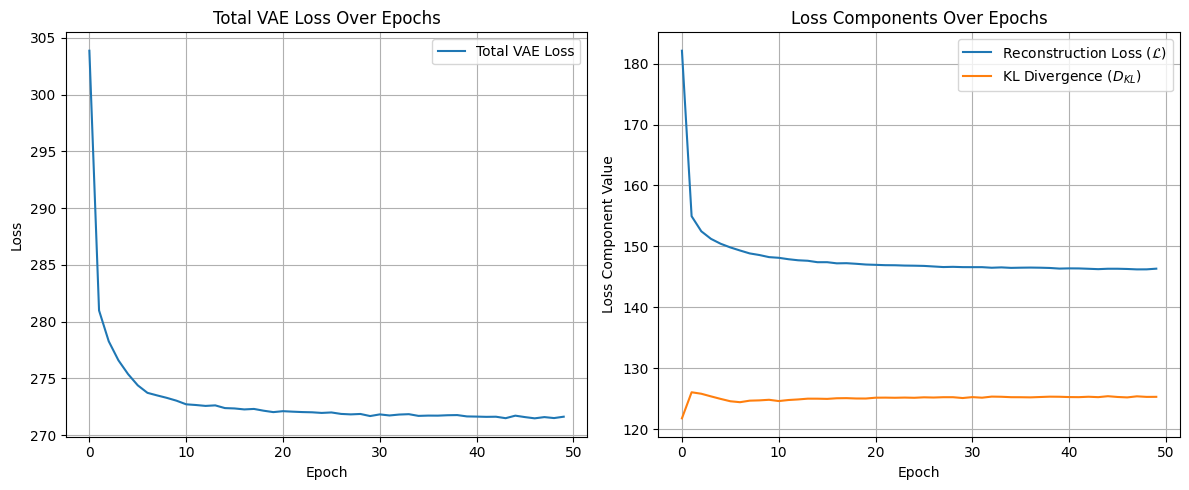


Displaying 8 original images and their reconstructions.
Format: [Original | Reconstructed | Original | Reconstructed | ...]


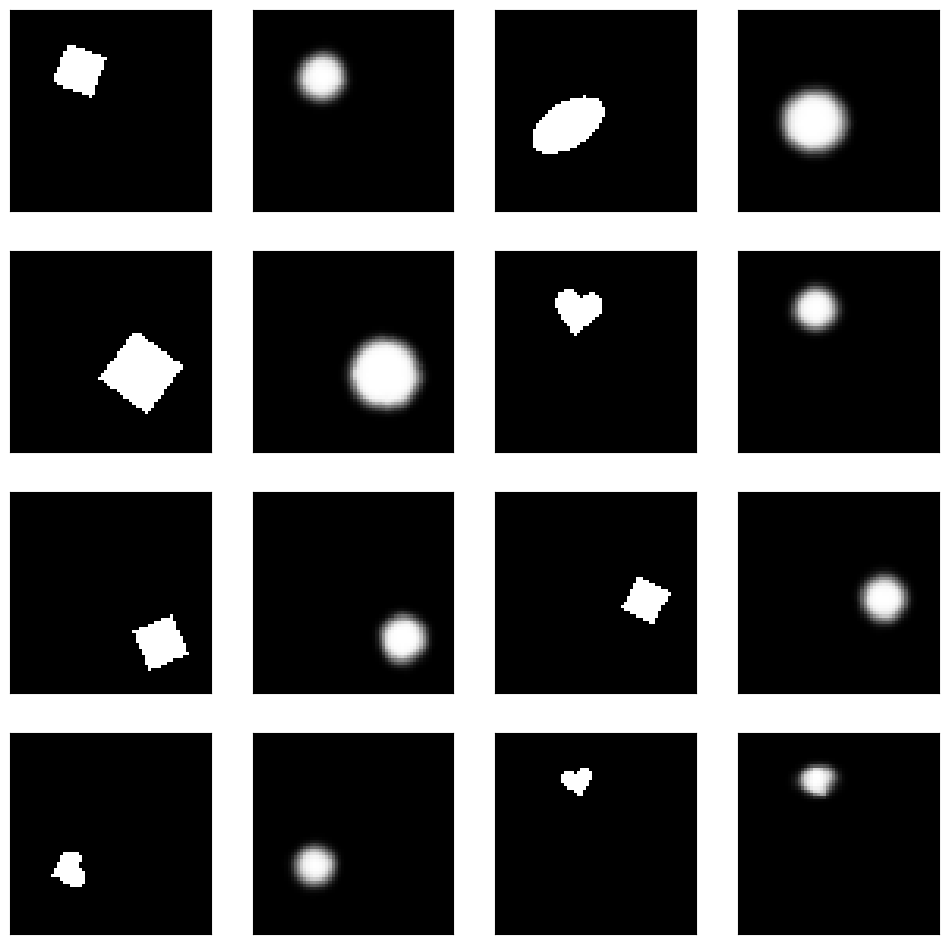

In [ ]:
#TRAINED WITHOUT CHECKPOINTING.
BATCH_SIZE = 32 # A common choice for VAEs
LATENT_DIM = 10 # A common choice, the table uses 'h_dim', let's set it to 10
EPOCHS = 50
INITIAL_LR = 0.001
BETA = 25

print(f"Starting training on device: {device}")
for epoch in range(1, EPOCHS + 1):
    train(epoch, BETA)
print("Training complete.")

# --- 8. Evaluation and Plotting (As requested) ---

## Loss History Plot 📈

print("\nPlotting Loss History...")
plt.figure(figsize=(12, 5))

# Plot Total Loss
plt.subplot(1, 2, 1)
plt.plot(history_total_loss, label='Total VAE Loss')
plt.title('Total VAE Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

# Plot Loss Components
plt.subplot(1, 2, 2)
plt.plot(history_bce_loss, label='Reconstruction Loss ($\mathcal{L}$)')
plt.plot(history_kld_loss, label='KL Divergence ($D_{KL}$)')
plt.title('Loss Components Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss Component Value')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

## Original vs. Reconstructed Images Comparison

# Select 8 random images (Original vs. Reconstructed)
model.eval()
NUM_SAMPLES = 8
random_indices = np.random.choice(len(dataset), NUM_SAMPLES, replace=False)
sample_images = dataset[random_indices].to(device)

with torch.no_grad():
    reconstructed_images, _, _ = model(sample_images)

# Prepare images for display:
# Combine original and reconstructed: [Original_1, Reconstructed_1, Original_2, Reconstructed_2, ...]
display_images = []
for i in range(NUM_SAMPLES):
    display_images.append(sample_images[i].cpu())
    display_images.append(reconstructed_images[i].cpu())

print(f"\nDisplaying {NUM_SAMPLES} original images and their reconstructions.")
print("Format: [Original | Reconstructed | Original | Reconstructed | ...]")

# Display 2*NUM_SAMPLES images (8 original + 8 reconstructed = 16 images)
show_images_grid(display_images, num_images=2 * NUM_SAMPLES)

In [ ]:
#WITH CHECKPOINTING.
BETA = 5.0
history_total_loss = []
history_bce_loss = []
history_kld_loss = []

start_time = time.time()
for epoch in range(1, EPOCHS + 1):
    model.train()
    train_loss = 0.0
    train_bce = 0.0
    train_kld = 0.0
    batch_start_time = time.time()

    for batch_idx, data in enumerate(train_loader):
        # data shape: (B, 1, 64, 64)
        data = data.to(device, non_blocking=PIN_MEMORY).float()
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss, bce, kld = vae_loss_function(recon_batch, data, mu, logvar, beta=BETA)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_bce += bce.item()
        train_kld += kld.item()

    avg_loss = train_loss / len(train_loader.dataset)
    avg_bce = train_bce / len(train_loader.dataset)
    avg_kld = train_kld / len(train_loader.dataset)

    history_total_loss.append(avg_loss)
    history_bce_loss.append(avg_bce)
    history_kld_loss.append(avg_kld)

    epoch_time = time.time() - batch_start_time
    print(f"Epoch {epoch:02d}/{EPOCHS}  Avg Loss: {avg_loss:.4f}  BCE: {avg_bce:.4f}  KLD: {avg_kld:.4f}  time: {epoch_time:.1f}s")

    # ✅ Save model every 10 epochs
    if epoch % 10 == 0:
      history = {
          'total_loss': history_total_loss,
          'bce': history_bce_loss,
          'kld': history_kld_loss
      }
      save_checkpoint("/content/drive/MyDrive",
                      model, optimizer, epoch,BETA,
                      scheduler=lr_scheduler if 'lr_scheduler' in globals() else None,
                      scaler=scaler if 'scaler' in globals() else None,
                      history=history,
                      prefix="vae")

total_time = time.time() - start_time
print(f"Training finished in {total_time/60:.2f} minutes.")

# Save final model too (optional)
final_save_path = f'/content/drive/MyDrive/vae_final_beta_{BETA}.pth'
torch.save(model.state_dict(), final_save_path)
print("Final model saved to:", final_save_path)


Epoch 01/50  Avg Loss: 124.8142  BCE: 58.8233  KLD: 65.9909  time: 74.4s
Epoch 02/50  Avg Loss: 124.4201  BCE: 58.4326  KLD: 65.9876  time: 74.0s
Epoch 03/50  Avg Loss: 124.0929  BCE: 58.0405  KLD: 66.0524  time: 73.3s
Epoch 04/50  Avg Loss: 123.8277  BCE: 57.7407  KLD: 66.0870  time: 73.4s
Epoch 05/50  Avg Loss: 123.5145  BCE: 57.4047  KLD: 66.1098  time: 73.2s
Epoch 06/50  Avg Loss: 123.3445  BCE: 57.1669  KLD: 66.1777  time: 73.3s
Epoch 07/50  Avg Loss: 123.1158  BCE: 56.8484  KLD: 66.2674  time: 73.1s
Epoch 08/50  Avg Loss: 122.9052  BCE: 56.6655  KLD: 66.2397  time: 73.0s
Epoch 09/50  Avg Loss: 122.7553  BCE: 56.4565  KLD: 66.2989  time: 73.6s
Epoch 10/50  Avg Loss: 122.5632  BCE: 56.2438  KLD: 66.3194  time: 72.8s
Saved checkpoint: /content/drive/MyDrive/vae_epoch_10.pth


KeyboardInterrupt: 

In [ ]:
import glob
import re

def find_latest_checkpoint(dirpath, prefix="vae"):
    files = glob.glob(os.path.join(dirpath, f"{prefix}_epoch_*.pth"))
    if not files:
        return None
    # extract epoch numbers and pick the largest
    def epoch_from_name(fn):
        m = re.search(rf"{prefix}_epoch_(\d+)\.pth", os.path.basename(fn))
        return int(m.group(1)) if m else -1
    latest = max(files, key=epoch_from_name)
    return latest

# ----- usage -----
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VAE(latent_dim=LATENT_DIM).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=INITIAL_LR)
if 'lr_scheduler' in globals(): lr_scheduler = ...
# if using AMP
# scaler = torch.cuda.amp.GradScaler()

ckpt_path = find_latest_checkpoint("/content/drive/MyDrive", prefix="vae")
if ckpt_path is not None:
    print("Loading checkpoint:", ckpt_path)
    ckpt = torch.load(ckpt_path, map_location=DEVICE)
    model.load_state_dict(ckpt['model_state'])
    optimizer.load_state_dict(ckpt['optimizer_state'])
    start_epoch = ckpt.get('epoch', 0) + 1
    if 'scheduler_state' in ckpt and 'lr_scheduler' in globals():
        lr_scheduler.load_state_dict(ckpt['scheduler_state'])
    if 'scaler_state' in ckpt and 'scaler' in globals():
        scaler.load_state_dict(ckpt['scaler_state'])
    history = ckpt.get('history', None)
    if history is not None:
        history_total_loss = history.get('total_loss', [])
        history_bce_loss = history.get('bce', [])
        history_kld_loss = history.get('kld', [])
    print(f"Resuming from epoch {start_epoch}")
else:
    print("No checkpoint found, starting from epoch 1")
    start_epoch = 1


Loading checkpoint: /content/drive/MyDrive/vae_epoch_30.pth
Resuming from epoch 31


In [ ]:
train_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=2, pin_memory=False)


In [ ]:
#CONTINUATION OF THE LAST PART.
BETA = 5.0
history_total_loss = []
history_bce_loss = []
history_kld_loss = []

start_time = time.time()
for epoch in range(start_epoch, EPOCHS + 1):
    model.train()
    train_loss = 0.0
    train_bce = 0.0
    train_kld = 0.0
    batch_start_time = time.time()

    for batch_idx, data in enumerate(train_loader):
        # data shape: (B, 1, 64, 64)
        data = data.to(device, non_blocking=PIN_MEMORY).float()
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss, bce, kld = vae_loss_function(recon_batch, data, mu, logvar, beta=BETA)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_bce += bce.item()
        train_kld += kld.item()

    avg_loss = train_loss / len(train_loader.dataset)
    avg_bce = train_bce / len(train_loader.dataset)
    avg_kld = train_kld / len(train_loader.dataset)

    history_total_loss.append(avg_loss)
    history_bce_loss.append(avg_bce)
    history_kld_loss.append(avg_kld)

    epoch_time = time.time() - batch_start_time
    print(f"Epoch {epoch:02d}/{EPOCHS}  Avg Loss: {avg_loss:.4f}  BCE: {avg_bce:.4f}  KLD: {avg_kld:.4f}  time: {epoch_time:.1f}s")

    # ✅ Save model every 10 epochs
    if epoch % 10 == 0:
      history = {
          'total_loss': history_total_loss,
          'bce': history_bce_loss,
          'kld': history_kld_loss
      }
      save_checkpoint("/content/drive/MyDrive",
                      model, optimizer, epoch, BETA,
                      scheduler=lr_scheduler if 'lr_scheduler' in globals() else None,
                      scaler=scaler if 'scaler' in globals() else None,
                      history=history,
                      prefix="vae")

total_time = time.time() - start_time
print(f"Training finished in {total_time/60:.2f} minutes.")

# Save final model too (optional)
final_save_path = f'/content/drive/MyDrive/vae_final_beta_{BETA}.pth'
torch.save(model.state_dict(), final_save_path)
print("Final model saved to:", final_save_path)

Epoch 31/50  Avg Loss: 119.5629  BCE: 52.3987  KLD: 67.1642  time: 80.2s
Epoch 32/50  Avg Loss: 119.5617  BCE: 52.3545  KLD: 67.2072  time: 80.1s
Epoch 33/50  Avg Loss: 119.4759  BCE: 52.2866  KLD: 67.1892  time: 81.3s
Epoch 34/50  Avg Loss: 119.4171  BCE: 52.1861  KLD: 67.2310  time: 80.5s
Epoch 35/50  Avg Loss: 119.4028  BCE: 52.1374  KLD: 67.2654  time: 80.8s
Epoch 36/50  Avg Loss: 119.3816  BCE: 52.0999  KLD: 67.2817  time: 82.2s
Epoch 37/50  Avg Loss: 119.3145  BCE: 52.0078  KLD: 67.3066  time: 82.0s
Epoch 38/50  Avg Loss: 119.2363  BCE: 51.9374  KLD: 67.2988  time: 81.8s
Epoch 39/50  Avg Loss: 119.1539  BCE: 51.8348  KLD: 67.3191  time: 81.8s
Epoch 40/50  Avg Loss: 119.1540  BCE: 51.7797  KLD: 67.3743  time: 81.9s
Saved checkpoint: /content/drive/MyDrive/vae_epoch_40_beta_5.0.pth
Epoch 41/50  Avg Loss: 119.0314  BCE: 51.6583  KLD: 67.3732  time: 81.7s
Epoch 42/50  Avg Loss: 118.9989  BCE: 51.6198  KLD: 67.3791  time: 80.1s
Epoch 43/50  Avg Loss: 118.9454  BCE: 51.5436  KLD: 67.40

In [ ]:
#WITH CHECKPOINTING.
BETA = 25.0
history_total_loss = []
history_bce_loss = []
history_kld_loss = []

start_time = time.time()
for epoch in range(1, EPOCHS + 1):
    model.train()
    train_loss = 0.0
    train_bce = 0.0
    train_kld = 0.0
    batch_start_time = time.time()

    for batch_idx, data in enumerate(train_loader):
        # data shape: (B, 1, 64, 64)
        data = data.to(device, non_blocking=PIN_MEMORY).float()
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss, bce, kld = vae_loss_function(recon_batch, data, mu, logvar, beta=BETA)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_bce += bce.item()
        train_kld += kld.item()

    avg_loss = train_loss / len(train_loader.dataset)
    avg_bce = train_bce / len(train_loader.dataset)
    avg_kld = train_kld / len(train_loader.dataset)

    history_total_loss.append(avg_loss)
    history_bce_loss.append(avg_bce)
    history_kld_loss.append(avg_kld)

    epoch_time = time.time() - batch_start_time
    print(f"Epoch {epoch:02d}/{EPOCHS}  Avg Loss: {avg_loss:.4f}  BCE: {avg_bce:.4f}  KLD: {avg_kld:.4f}  time: {epoch_time:.1f}s")

    # ✅ Save model every 10 epochs
    if epoch % 10 == 0:
      history = {
          'total_loss': history_total_loss,
          'bce': history_bce_loss,
          'kld': history_kld_loss
      }
      save_checkpoint("/content/drive/MyDrive",
                      model, optimizer, epoch,BETA,
                      scheduler=lr_scheduler if 'lr_scheduler' in globals() else None,
                      scaler=scaler if 'scaler' in globals() else None,
                      history=history,
                      prefix="vae")

total_time = time.time() - start_time
print(f"Training finished in {total_time/60:.2f} minutes.")

# Save final model too (optional)
final_save_path = f'/content/drive/MyDrive/vae_final_beta_{BETA}.pth'
torch.save(model.state_dict(), final_save_path)
print("Final model saved to:", final_save_path)


Epoch 01/50  Avg Loss: 286.3116  BCE: 146.9621  KLD: 139.3495  time: 82.6s
Epoch 02/50  Avg Loss: 282.8404  BCE: 147.2219  KLD: 135.6185  time: 81.3s
Epoch 03/50  Avg Loss: 281.3091  BCE: 146.5229  KLD: 134.7862  time: 83.4s
Epoch 04/50  Avg Loss: 280.4371  BCE: 146.2314  KLD: 134.2057  time: 82.1s
Epoch 05/50  Avg Loss: 279.9805  BCE: 146.0516  KLD: 133.9289  time: 83.4s
Epoch 06/50  Avg Loss: 279.4960  BCE: 145.8621  KLD: 133.6339  time: 81.7s
Epoch 07/50  Avg Loss: 278.9708  BCE: 145.7082  KLD: 133.2626  time: 81.5s
Epoch 08/50  Avg Loss: 278.6364  BCE: 145.6310  KLD: 133.0055  time: 80.2s
Epoch 09/50  Avg Loss: 278.1623  BCE: 145.6836  KLD: 132.4787  time: 79.9s
Epoch 10/50  Avg Loss: 277.6984  BCE: 145.6617  KLD: 132.0367  time: 79.6s
Saved checkpoint: /content/drive/MyDrive/vae_epoch_10_beta_25.0.pth
Epoch 11/50  Avg Loss: 277.3165  BCE: 145.6456  KLD: 131.6709  time: 80.3s
Epoch 12/50  Avg Loss: 276.9912  BCE: 145.7607  KLD: 131.2305  time: 80.2s
Epoch 13/50  Avg Loss: 276.5810 

In [12]:
import torch
import matplotlib.pyplot as plt
import numpy as np
def print_reconstructions(model, dataset, ckpt_path, num_samples=8):

  ckpt = torch.load(ckpt_path, map_location="cpu")
  model.load_state_dict(ckpt)
  model = model.float()
  model.eval()

  idxs = np.random.choice(len(dataset), num_samples, replace=False)
  sample_images = torch.stack([dataset[i][0] for i in idxs]).to(device).float()


  with torch.no_grad():
      reconstructed_images, _, _ = model(sample_images)

  display_images = []
  for i in range(num_samples):
      display_images.append(sample_images[i].cpu())
      display_images.append(reconstructed_images[i].cpu())

  print(f"\nDisplaying {num_samples} original and reconstructed images.")
  show_images_grid(display_images, num_images=2 * num_samples)



Displaying 8 original and reconstructed images.


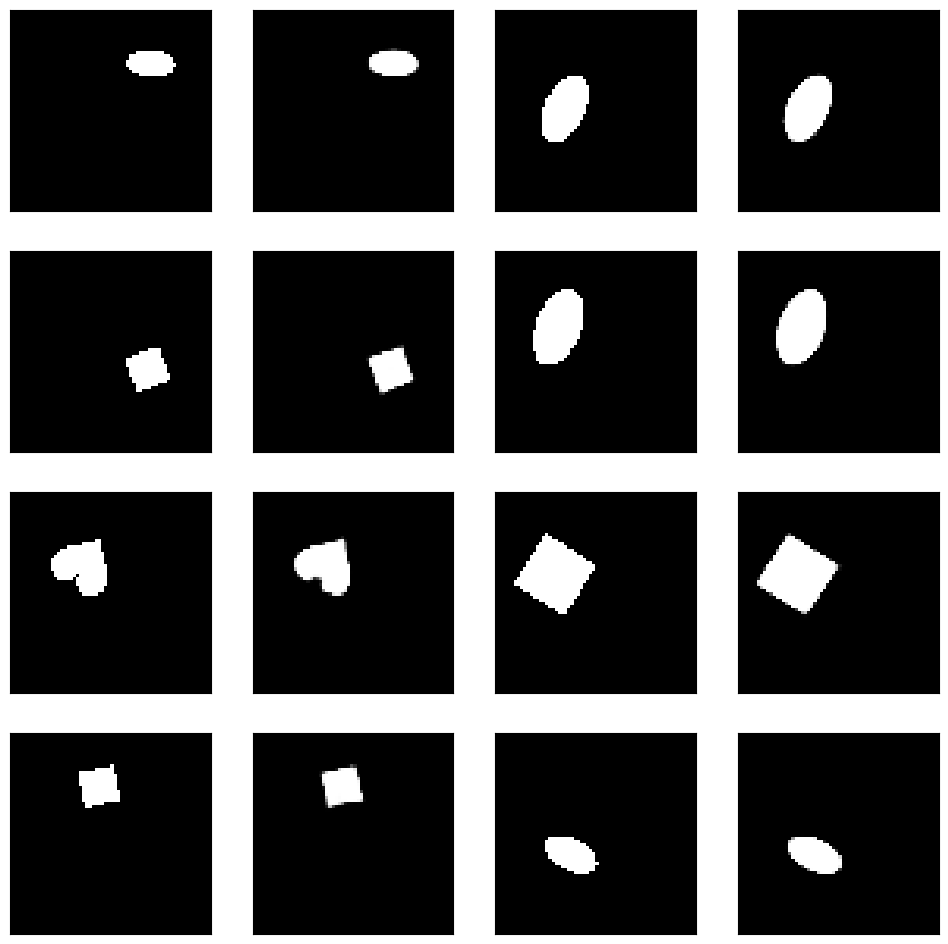

In [ ]:
print_reconstructions(model, dataset, "/content/drive/MyDrive/vae_final_beta_1.0.pth")


Displaying 8 original and reconstructed images.


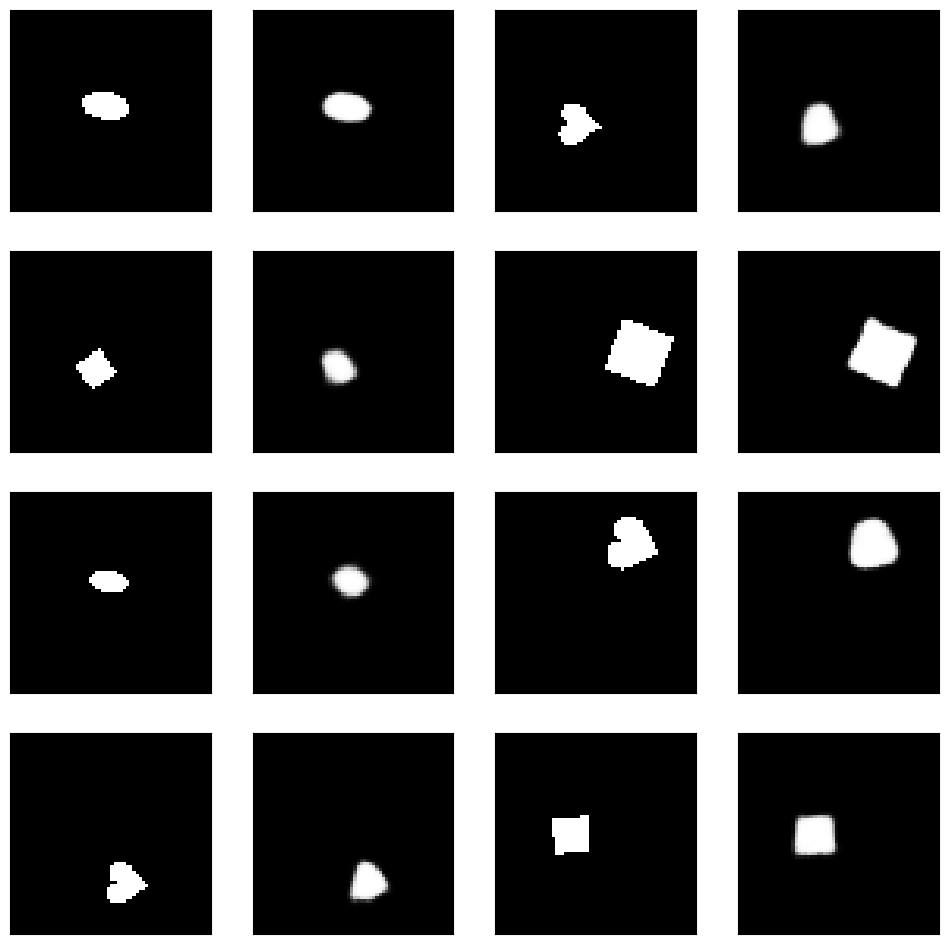

In [ ]:
print_reconstructions(model, dataset, "/content/drive/MyDrive/vae_final_beta_5.0.pth")


Displaying 8 original and reconstructed images.


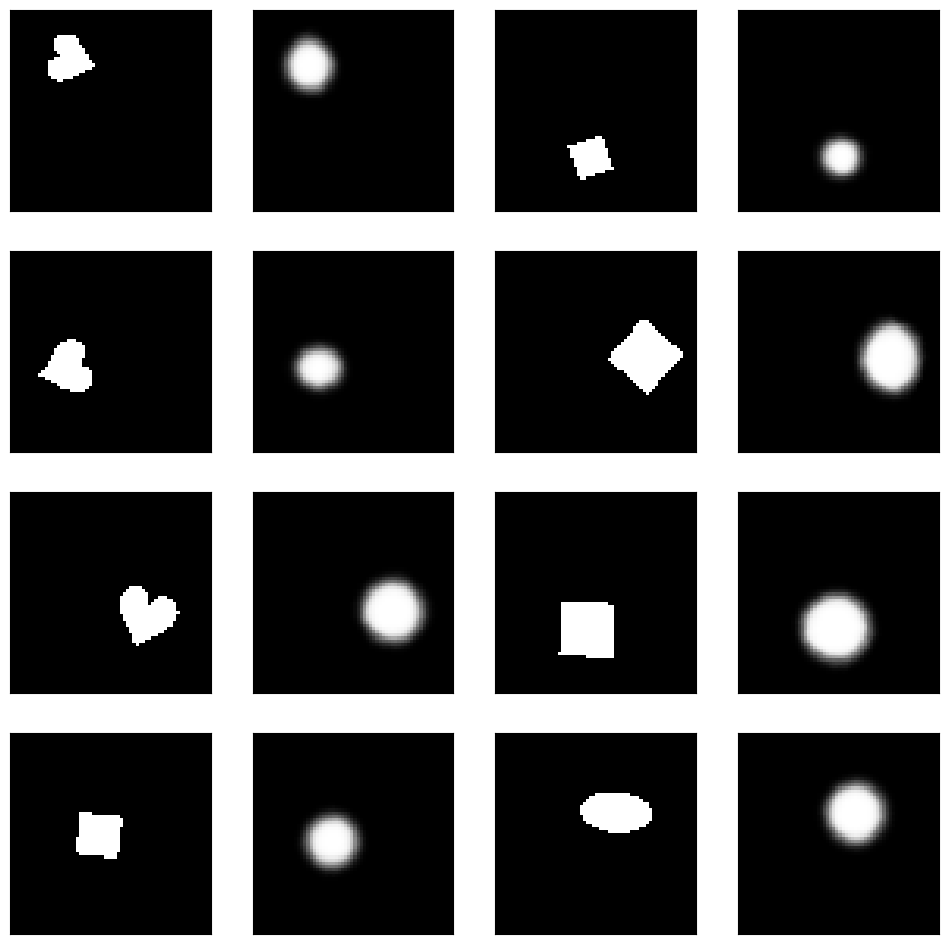

In [ ]:
print_reconstructions(model, dataset, "/content/drive/MyDrive/vae_final_beta_25.0.pth")

In [16]:
dataset = DspritesMemmapDataset(imgs, npz['latents_values'])



# ----------------------------

# --- ANALYSIS START ---
# This section REPLACES the flawed manual extraction/trimming attempts.

# 1. FIX: Get ALL factors directly from the loaded memmap_factors array/file
# This is now SAFE as it comes directly from the source array, NOT the DataLoader output.
all_dataset_factors = np.asarray(npz['latents_values'], dtype=np.float32)


# 2. Extract Latent Codes and Factors from the CORRECTED DataLoader

def extract_latent_and_factors_final(model, data_loader, num_samples, device):
    model.eval()

    latent_codes = []
    total_samples = 0

    with torch.no_grad():
        for i, (images, factors) in tqdm(enumerate(data_loader)):

            if total_samples >= num_samples:
                break

            current_batch_size = images.shape[0]

            # Trim last batch if necessary
            if total_samples + current_batch_size > num_samples:
                required_samples = num_samples - total_samples
                images = images[:required_samples]
                # No need to trim factors here, we use the pre-loaded factor array
                current_batch_size = required_samples

            # Image processing (already done in DataLoader, but ensure device)
            images = images.to(device).float()

            mu, logvar = model.encode(images)

            # Store latent codes
            mu_np = mu.cpu().numpy().reshape(current_batch_size, -1)
            latent_codes.append(mu_np)

            total_samples += current_batch_size

    all_latent_codes = np.concatenate(latent_codes, axis=0)
    final_len = all_latent_codes.shape[0]

    return all_latent_codes, final_len


In [15]:
import torch
from tqdm import tqdm
import numpy as np

# Assuming LATENT_DIM and NUM_FACTORS (6 for dsprites) are defined
# Assuming image dimension is 64x64 (4096 total elements)
IMAGE_ELEMENTS = 4096
NUM_FACTORS = 6 # Set this to your actual number of factors

def extract_latent_and_factors(model, data_loader, num_samples, device):
    """
    Extracts latent codes and factors by dynamically identifying image and
    factor tensors based on their expected size (4096 for images, NUM_FACTORS for factors).
    """
    model.eval()

    latent_codes = []
    true_factors = []
    total_collected_samples = 0
    batch_size = data_loader.batch_size
    target_batches = num_samples // batch_size + (1 if num_samples % batch_size != 0 else 0)

    with torch.no_grad():
        for i, batch_data in tqdm(enumerate(data_loader), total=target_batches):

            # --- Stop Condition ---
            if total_collected_samples >= num_samples:
                break

            # 1. IDENTIFY AND ASSIGN TENSORS BASED ON SIZE
            # Flatten the tensors to count elements per sample, ignoring the batch dimension.
            item0_elements = batch_data[0].flatten(start_dim=1).shape[1]
            item1_elements = batch_data[1].flatten(start_dim=1).shape[1]

            if item0_elements == IMAGE_ELEMENTS and item1_elements == NUM_FACTORS:
                # Case: (Image, Factors, ...) - The standard dsprites return format
                images, factors = batch_data[0], batch_data[1]
            elif item0_elements == NUM_FACTORS and item1_elements == IMAGE_ELEMENTS:
                # Case: (Factors, Image, ...) - The swapped format
                factors, images = batch_data[0], batch_data[1]
            else:
                # This handles the specific failure case where BOTH were images, or shapes are corrupted
                print(f"\nFATAL ERROR: Batch {i} contains corrupted or unknown data shapes.")
                print(f"Item 0 shape: {batch_data[0].shape}, Item 1 shape: {batch_data[1].shape}")
                # Use the safer assumption, but stop the loop
                break

            current_batch_size = images.shape[0]

            # 2. TRIM LAST BATCH
            if total_collected_samples + current_batch_size > num_samples:
                required_samples = num_samples - total_collected_samples

                # Trim all collected tensors consistently
                images = images[:required_samples]
                factors = factors[:required_samples]
                current_batch_size = required_samples

            # 3. ENCODE
            images = images.to(device).float()
            if images.ndim == 3:
                images = images.unsqueeze(1)

            mu, logvar = model.encode(images)

            # 4. SHAPE CONTROL (Now safe, as we checked factors_np size)
            mu_np = mu.cpu().numpy().reshape(current_batch_size, -1)
            factors_np = factors.cpu().numpy().reshape(current_batch_size, NUM_FACTORS)

            # 5. STORAGE
            latent_codes.append(mu_np)
            true_factors.append(factors_np)

            total_collected_samples += current_batch_size

    # 6. FINAL CONCATENATION
    all_latent_codes = np.concatenate(latent_codes, axis=0)
    all_true_factors = np.concatenate(true_factors, axis=0)

    print("\n--- FINAL OUTPUT SHAPES ---")
    print(f"FINAL Latent Code Samples: {all_latent_codes.shape}")
    print(f"FINAL Factor Samples: {all_true_factors.shape}")

    return all_latent_codes, all_true_factors

In [22]:
from sklearn.metrics import mutual_info_score
import numpy as np

# Retain the discretize_latent function (since it handles continuous latent space)
def discretize_latent(latent_codes, num_bins=10):
    """Discretizes each dimension of the latent codes into bins."""
    discretized = np.zeros_like(latent_codes, dtype=int)
    for i in range(latent_codes.shape[1]):
        # Adjust bins or use uniform binning if percentile causes issues with constant data
        boundaries = np.percentile(latent_codes[:, i], np.linspace(0, 100, num_bins + 1)[1:-1])
        discretized[:, i] = np.digitize(latent_codes[:, i], boundaries)
    return discretized

def compute_mig_score(latent_codes, true_factors, num_bins=20):

    discretized_z = discretize_latent(latent_codes, num_bins)

    num_latents = latent_codes.shape[1]
    num_factors = true_factors.shape[1]

    mi_matrix = np.zeros((num_latents, num_factors))
    mig_scores_by_factor = []

    for k in range(num_factors):
        # 1. CRITICAL FIX: Convert continuous factor values to discrete integer labels
        true_factor_k_values = true_factors[:, k].flatten()
        # np.unique returns unique values and their inverse indices (labels)
        _, true_factor_k_labels = np.unique(true_factor_k_values, return_inverse=True)

        # 2. Calculate factor entropy H(Vk) using the new discrete labels
        _, factor_counts = np.unique(true_factor_k_labels, return_counts=True)
        prob = factor_counts / len(true_factor_k_labels)
        H_Vk = -np.sum(prob[prob > 0] * np.log(prob[prob > 0]))

        # --- Handle Zero Entropy (constant factor) ---
        if H_Vk < 1e-6:
            print(f"Warning: Factor {k} has zero entropy (constant value). Skipping MIG calculation for this factor.")
            mig_scores_by_factor.append(None) # Append None to maintain factor index
            continue
        # ---------------------------------------------

        for j in range(num_latents):
            discretized_latent_j = discretized_z[:, j].flatten()

            # Use the discrete factor labels and the discretized latent codes
            mi = mutual_info_score(true_factor_k_labels, discretized_latent_j)

            mi_matrix[j, k] = mi / H_Vk

        # 3. Compute MIG for the current factor
        sorted_mi = np.sort(mi_matrix[:, k])[::-1]
        mig_k = sorted_mi[0] - sorted_mi[1]
        mig_scores_by_factor.append(mig_k)

    # Calculate overall MIG only over factors that were successfully computed
    non_skipped_scores = [score for score in mig_scores_by_factor if score is not None]
    overall_mig = np.mean(non_skipped_scores) if non_skipped_scores else np.nan

    return overall_mig, non_skipped_scores

In [14]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd

def perform_pca_and_plot(latent_codes, true_factors, title="PCA Scatter Plot"):
    """Performs PCA and plots the latent codes colored by the first factor (e.g., Shape)."""

    # 1. Apply PCA
    pca = PCA(n_components=2)
    # Fit and transform the data
    components = pca.fit_transform(latent_codes)

    # The first factor in dsprites is typically Shape (index 1 after Color at 0)
    # Use index 1 for the shape factor for coloring
    coloring_factor = true_factors[:, 1]

    # 2. Plotting
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(
        components[:, 0],
        components[:, 1],
        c=coloring_factor, # Color points by the ground-truth factor
        cmap='viridis',
        s=10,
        alpha=0.6
    )

    # Add a color bar and labels
    cbar = plt.colorbar(scatter)
    cbar.set_label('Ground-Truth Shape Factor')

    plt.xlabel(f'Principal Component 1 ({pca.explained_variance_ratio_[0]*100:.2f}%)')
    plt.ylabel(f'Principal Component 2 ({pca.explained_variance_ratio_[1]*100:.2f}%)')
    plt.title(title)
    plt.grid(True, linestyle='--', alpha=0.6)

    # Save the plot
    plt.savefig(f"{title.replace(' ', '_')}.png")
    plt.close()


In [17]:
import torch

# --- Setup (Assumed Variables) ---
# LATENT_DIM: The size of the latent space (e.g., 10, 32, etc.)
# VAE: The class definition for your Variational Autoencoder
# device: The device for running the model (e.g., torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

# --- Checkpoint Paths (Example) ---
# You need to define the paths to your three saved models:
CKPT_PATH_VAE = "/content/drive/MyDrive/vae_final_beta_1.0.pth"
CKPT_PATH_BVAE_LOW = "/content/drive/MyDrive/vae_final_beta_8.0.pth"   # Example low beta
CKPT_PATH_BVAE_HIGH = "/content/drive/MyDrive/vae_final_beta_25.0.pth" # Example high beta

def load_model(ckpt_path, latent_dim, device):
    """Loads a VAE model from a checkpoint dictionary."""
    print(f"Loading model from: {ckpt_path}")

    # Load the checkpoint dictionary (must contain the state_dict directly)
    ckpt = torch.load(ckpt_path, map_location=device)

    # Instantiate the model
    model = VAE(latent_dim=latent_dim).to(device)

    # Load the state dictionary directly (assuming it's not nested under 'model_state')
    model.load_state_dict(ckpt)

    # Ensure consistency (if trained using float32, keep it float32)
    model.float()
    model.eval()

    return model

# --- Model Specification ---

# 1. Standard VAE (Beta=1)
model_vae = load_model(CKPT_PATH_VAE, LATENT_DIM, device)

# 2. Beta-VAE (Low Beta)
model_bvae_low = load_model(CKPT_PATH_BVAE_LOW, LATENT_DIM, device)

# 3. Beta-VAE (High Beta)
model_bvae_high = load_model(CKPT_PATH_BVAE_HIGH, LATENT_DIM, device)

Loading model from: /content/drive/MyDrive/vae_final_beta_1.0.pth
Loading model from: /content/drive/MyDrive/vae_final_beta_8.0.pth
Loading model from: /content/drive/MyDrive/vae_final_beta_25.0.pth


In [18]:
# --- Assuming you have the dsprites_loader defined ---
NUM_SAMPLES = 10000

# 1. Extract data for VAE
latent_vae, factors_vae = extract_latent_and_factors_final(
    model=model_vae,
    data_loader=train_loader,
    num_samples=NUM_SAMPLES,
    device=device
)

# 2. Extract data for Beta-VAE (Low Beta)
latent_bvae_low, factors_bvae_low = extract_latent_and_factors_final(
    model=model_bvae_low,
    data_loader=train_loader,
    num_samples=NUM_SAMPLES,
    device=device
)

# 3. Extract data for Beta-VAE (High Beta)
latent_bvae_high, factors_bvae_high = extract_latent_and_factors_final(
    model=model_bvae_high,
    data_loader=train_loader,
    num_samples=NUM_SAMPLES,
    device=device
)

79it [00:00, 121.02it/s]
79it [00:00, 109.32it/s]
79it [00:00, 107.06it/s]


In [19]:
import numpy as np

# Assuming latent_vae holds the extracted mu vectors with shape (NumSamples, LatentDim)

# 1. Check the mean of all mu vectors (should be near 0 if collapsed)
mean_of_all_mus = np.mean(latent_vae)

# 2. Check the standard deviation of the means for each latent dimension
# This shows how much the mean vector changes across different images.
# If collapsed, the means of all dimensions should be close to zero, and the overall std should be low.
std_of_mus = np.std(latent_vae, axis=0) # Standard deviation for each latent dimension

# Print the diagnostics
print(f"Total number of samples extracted: {latent_vae.shape[0]}")
print(f"Latent Dimension size: {latent_vae.shape[1]}")
print("-----------------------------------------")
print(f"Overall Mean of Latent Means (mu): {mean_of_all_mus:.4f}")
print(f"Mean Standard Deviation across all dimensions: {np.mean(std_of_mus):.4f}")
print("-----------------------------------------")
print("Standard Deviation for first 5 Latent Dimensions:")
print(std_of_mus[:5])

Total number of samples extracted: 10000
Latent Dimension size: 10
-----------------------------------------
Overall Mean of Latent Means (mu): -0.0010
Mean Standard Deviation across all dimensions: 0.9911
-----------------------------------------
Standard Deviation for first 5 Latent Dimensions:
[0.9848372  0.98341316 0.98673576 1.0131737  0.8917998 ]


In [20]:
factors_for_analysis = all_dataset_factors[:factors_vae]

In [ ]:
# Calculate MIG for all three models
mig_vae, _ = compute_mig_score(latent_vae, factors_for_analysis)
mig_bvae_low, _ = compute_mig_score(latent_bvae_low, factors_for_analysis)
mig_bvae_high, _ = compute_mig_score(latent_bvae_high, factors_for_analysis)

print(f"MIG Score VAE: {mig_vae:.4f}")
print(f"MIG Score B-VAE (Low): {mig_bvae_low:.4f}")
print(f"MIG Score B-VAE (High): {mig_bvae_high:.4f}")

In [24]:
# Use the latent codes and factors from the chosen model (e.g., VAE)
perform_pca_and_plot(
    latent_codes=latent_bvae_low,
    true_factors=factors_for_analysis,
    title="VAE Latent Space PCA Plot (Color by Shape)"
)

In [ ]:
# --- MIG Calculation Settings (New) ---
MIG_CALC_FREQUENCY = 1 # Calculate MIG every N epochs (e.g., every 5 epochs)
MIG_SUBSET_SIZE = 10000 # Use a subset of the data for faster MIG calculation (set to None for all data)
history_mig_score = [] # To track the MIG score over epochs

start_epoch = 1

BETA = 8.0
history_total_loss = []
history_bce_loss = []
history_kld_loss = []
history_mig_score = [] # Added for MIG tracking

print(f"Starting training with BETA={BETA}, Latent Dim={LATENT_DIM}")

start_time = time.time()
for epoch in range(start_epoch, EPOCHS + 1):
    # ----------------------------------------------------
    # PHASE 1: TRAINING
    # ----------------------------------------------------
    model.train()
    train_loss = 0.0
    train_bce = 0.0
    train_kld = 0.0
    batch_start_time = time.time()

    for batch_idx, (data, factors) in enumerate(train_loader):
        # data shape: (B, 1, 64, 64)
        data = data.to(device, non_blocking=PIN_MEMORY) # float conversion moved to vae_loss_function_standard
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)

        # Use the corrected loss function
        loss, bce, kld = vae_loss_function_standard(recon_batch, data, mu, logvar, beta=BETA)

        loss.backward()
        optimizer.step()

        # NOTE: Loss is now averaged per sample by vae_loss_function_standard
        train_loss += loss.item() * data.size(0) # Multiply by batch size to get sum of loss
        train_bce += bce.item() * data.size(0)
        train_kld += kld.item() * data.size(0)

    num_samples = len(train_loader.dataset) # Total dataset size
    avg_loss = train_loss / num_samples
    avg_bce = train_bce / num_samples
    avg_kld = train_kld / num_samples

    history_total_loss.append(avg_loss)
    history_bce_loss.append(avg_bce)
    history_kld_loss.append(avg_kld)

    epoch_time = time.time() - batch_start_time
    log_line = f"Epoch {epoch:02d}/{EPOCHS}  Avg Loss: {avg_loss:.4f}  BCE: {avg_bce:.4f}  KLD: {avg_kld:.4f}  time: {epoch_time:.1f}s"


    # ----------------------------------------------------
    # PHASE 2: MIG SCORE CALCULATION (Evaluation Mode)
    # ----------------------------------------------------
    current_mig = np.nan
    if epoch % MIG_CALC_FREQUENCY == 0 or epoch == EPOCHS:
        print("Calculating MIG score...")
        model.eval()
        latent_codes_list = []
        true_factors_list = []

        # Create a special DataLoader for evaluation (no shuffle, no workers needed if already memmap)
        # Using the existing train_loader is okay if we break early for subset.

        with torch.no_grad():
            for batch_idx, (data, factors) in enumerate(train_loader):
                # Apply subset logic
                if MIG_SUBSET_SIZE is not None and len(latent_codes_list) * BATCH_SIZE >= MIG_SUBSET_SIZE:
                    break

                data = data.to(device, non_blocking=PIN_MEMORY)
                mu, _ = model.encode(data) # Only need mu for the latent code

                latent_codes_list.append(mu.cpu().numpy())
                true_factors_list.append(factors.cpu().numpy())

        # Concatenate all batches
        latent_codes = np.concatenate(latent_codes_list, axis=0)
        true_factors = np.concatenate(true_factors_list, axis=0)

        # Trim to subset size if needed (important if last batch exceeded the limit)
        if MIG_SUBSET_SIZE is not None:
             latent_codes = latent_codes[:MIG_SUBSET_SIZE]
             true_factors = true_factors[:MIG_SUBSET_SIZE]

        # Compute MIG
        current_mig, _ = compute_mig_score(latent_codes, true_factors, num_bins=20)
        current_mig = current_mig.item() # Convert from numpy scalar

        history_mig_score.append(current_mig)
        log_line += f" | MIG: {current_mig:.4f}"

    print(log_line)

    # ----------------------------------------------------
    # PHASE 3: CHECKPOINTING
    # ----------------------------------------------------
    # ✅ Save model every 10 epochs
    if epoch % 10 == 0:
        # Note: You need to define 'save_checkpoint' function in a previous cell
        # to prevent a NameError.
        history = {
            'total_loss': history_total_loss,
            'bce': history_bce_loss,
            'kld': history_kld_loss,
            'mig': history_mig_score # Include MIG in history
        }
        # Assuming save_checkpoint is defined elsewhere...
        # save_checkpoint(...)
        save_checkpoint("/content/drive/MyDrive",
                      model, optimizer, epoch, BETA,
                      scheduler=lr_scheduler if 'lr_scheduler' in globals() else None,
                      scaler=scaler if 'scaler' in globals() else None,
                      history=history,
                      prefix="vae")

total_time = time.time() - start_time
print(f"Training finished in {total_time/60:.2f} minutes.")

# Save final model too (optional)
final_save_path = f'/content/drive/MyDrive/vae_final_beta_{BETA}.pth'
torch.save(model.state_dict(), final_save_path)
print("Final model saved to:", final_save_path)

Starting training with BETA=8.0, Latent Dim=10
Calculating MIG score...
Epoch 01/50  Avg Loss: 194.7860  BCE: 121.1058  KLD: 73.6802  time: 75.3s | MIG: 0.0511
Calculating MIG score...
Epoch 02/50  Avg Loss: 167.9970  BCE: 91.0341  KLD: 76.9629  time: 74.6s | MIG: 0.0488
Calculating MIG score...
Epoch 03/50  Avg Loss: 164.6782  BCE: 86.0781  KLD: 78.6001  time: 74.8s | MIG: 0.0491
Calculating MIG score...
Epoch 04/50  Avg Loss: 162.6584  BCE: 83.3312  KLD: 79.3272  time: 74.2s | MIG: 0.0534
Calculating MIG score...
Epoch 05/50  Avg Loss: 161.1307  BCE: 81.5020  KLD: 79.6287  time: 74.3s | MIG: 0.0584
Calculating MIG score...
Epoch 06/50  Avg Loss: 159.9748  BCE: 80.1492  KLD: 79.8256  time: 73.8s | MIG: 0.0653
Calculating MIG score...
Epoch 07/50  Avg Loss: 158.9837  BCE: 79.1197  KLD: 79.8640  time: 74.0s | MIG: 0.0710
Calculating MIG score...
Epoch 08/50  Avg Loss: 158.1569  BCE: 78.2251  KLD: 79.9318  time: 73.6s | MIG: 0.0803
Calculating MIG score...
Epoch 09/50  Avg Loss: 157.3212


Displaying 8 original and reconstructed images.


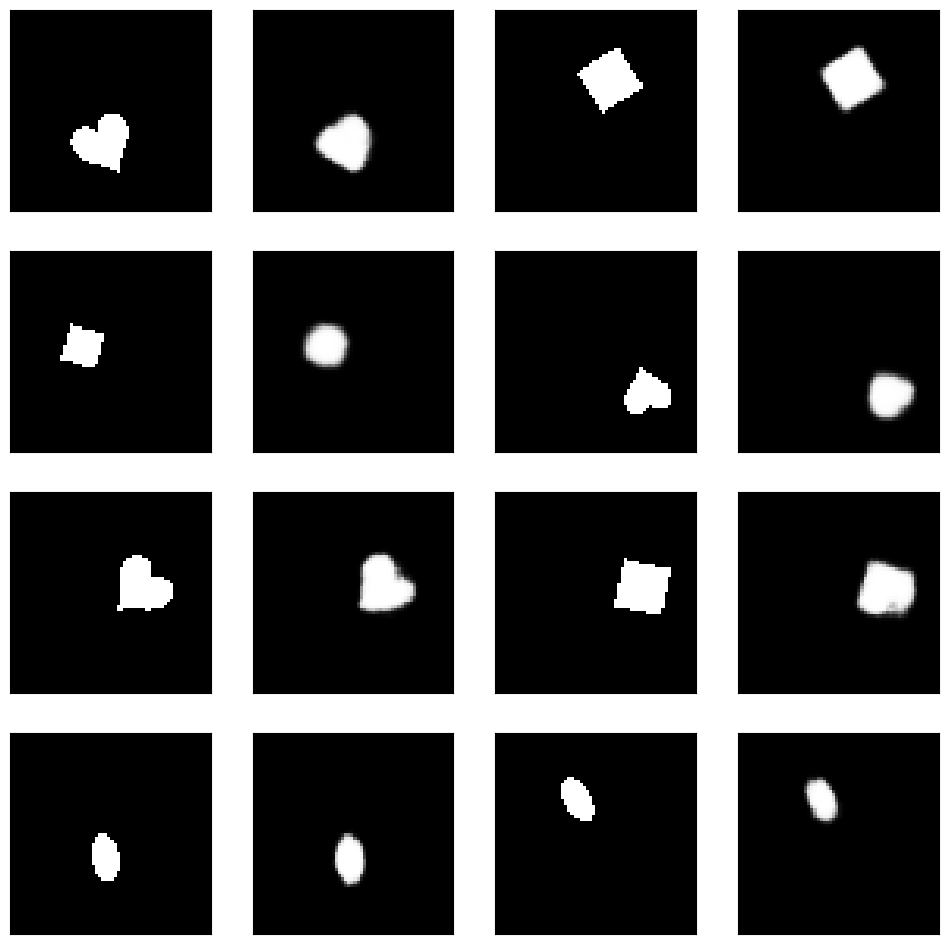

In [ ]:
print_reconstructions(model, dataset, "/content/drive/MyDrive/vae_final_beta_8.0.pth")


Displaying 8 original and reconstructed images.


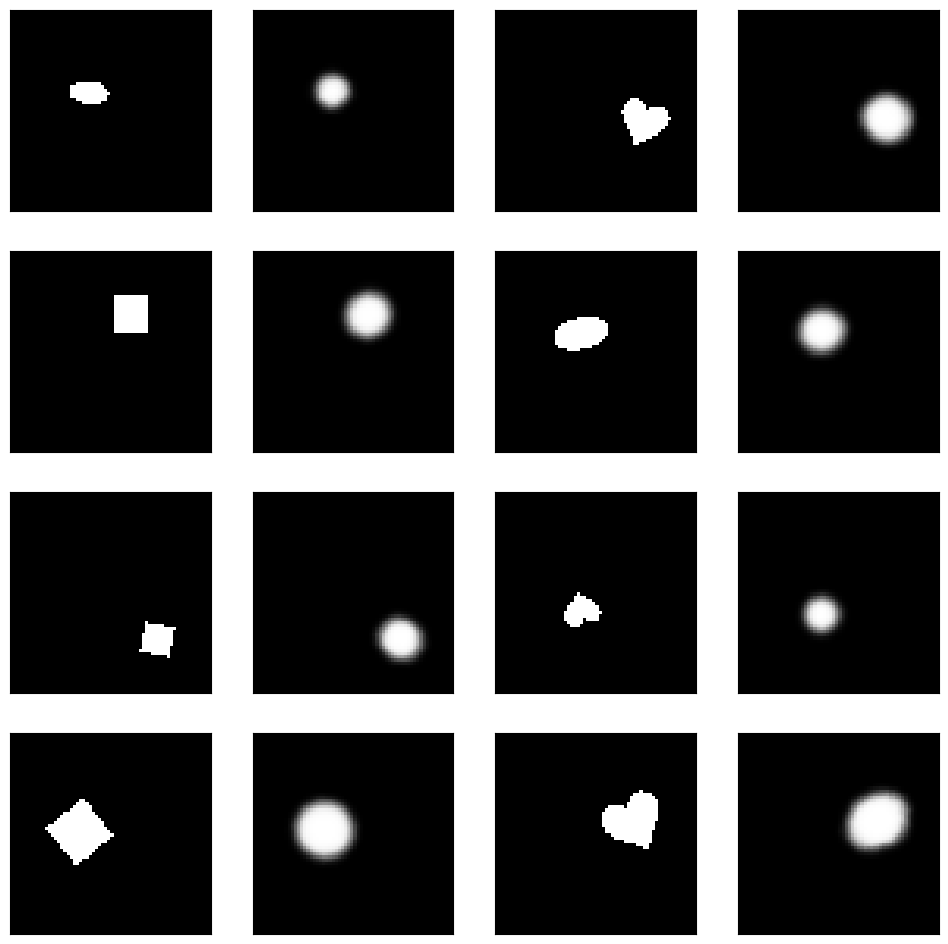

In [13]:
print_reconstructions(model, dataset, "/content/drive/MyDrive/vae_final_beta_20.0.pth")

In [ ]:
# --- MIG Calculation Settings (New) ---
MIG_CALC_FREQUENCY = 1 # Calculate MIG every N epochs (e.g., every 5 epochs)
MIG_SUBSET_SIZE = 10000 # Use a subset of the data for faster MIG calculation (set to None for all data)
history_mig_score = [] # To track the MIG score over epochs

start_epoch = 1

BETA = 20.0
history_total_loss = []
history_bce_loss = []
history_kld_loss = []
history_mig_score = [] # Added for MIG tracking

print(f"Starting training with BETA={BETA}, Latent Dim={LATENT_DIM}")

start_time = time.time()
for epoch in range(start_epoch, EPOCHS + 1):
    # ----------------------------------------------------
    # PHASE 1: TRAINING
    # ----------------------------------------------------
    model.train()
    train_loss = 0.0
    train_bce = 0.0
    train_kld = 0.0
    batch_start_time = time.time()

    for batch_idx, (data, factors) in enumerate(train_loader):
        # data shape: (B, 1, 64, 64)
        data = data.to(device, non_blocking=PIN_MEMORY) # float conversion moved to vae_loss_function_standard
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)

        # Use the corrected loss function
        loss, bce, kld = vae_loss_function_standard(recon_batch, data, mu, logvar, beta=BETA)

        loss.backward()
        optimizer.step()

        # NOTE: Loss is now averaged per sample by vae_loss_function_standard
        train_loss += loss.item() * data.size(0) # Multiply by batch size to get sum of loss
        train_bce += bce.item() * data.size(0)
        train_kld += kld.item() * data.size(0)

    num_samples = len(train_loader.dataset) # Total dataset size
    avg_loss = train_loss / num_samples
    avg_bce = train_bce / num_samples
    avg_kld = train_kld / num_samples

    history_total_loss.append(avg_loss)
    history_bce_loss.append(avg_bce)
    history_kld_loss.append(avg_kld)

    epoch_time = time.time() - batch_start_time
    log_line = f"Epoch {epoch:02d}/{EPOCHS}  Avg Loss: {avg_loss:.4f}  BCE: {avg_bce:.4f}  KLD: {avg_kld:.4f}  time: {epoch_time:.1f}s"


    # ----------------------------------------------------
    # PHASE 2: MIG SCORE CALCULATION (Evaluation Mode)
    # ----------------------------------------------------
    current_mig = np.nan
    if epoch % MIG_CALC_FREQUENCY == 0 or epoch == EPOCHS:
        print("Calculating MIG score...")
        model.eval()
        latent_codes_list = []
        true_factors_list = []

        # Create a special DataLoader for evaluation (no shuffle, no workers needed if already memmap)
        # Using the existing train_loader is okay if we break early for subset.

        with torch.no_grad():
            for batch_idx, (data, factors) in enumerate(train_loader):
                # Apply subset logic
                if MIG_SUBSET_SIZE is not None and len(latent_codes_list) * BATCH_SIZE >= MIG_SUBSET_SIZE:
                    break

                data = data.to(device, non_blocking=PIN_MEMORY)
                mu, _ = model.encode(data) # Only need mu for the latent code

                latent_codes_list.append(mu.cpu().numpy())
                true_factors_list.append(factors.cpu().numpy())

        # Concatenate all batches
        latent_codes = np.concatenate(latent_codes_list, axis=0)
        true_factors = np.concatenate(true_factors_list, axis=0)

        # Trim to subset size if needed (important if last batch exceeded the limit)
        if MIG_SUBSET_SIZE is not None:
             latent_codes = latent_codes[:MIG_SUBSET_SIZE]
             true_factors = true_factors[:MIG_SUBSET_SIZE]

        # Compute MIG
        current_mig, _ = compute_mig_score(latent_codes, true_factors, num_bins=20)
        current_mig = current_mig.item() # Convert from numpy scalar

        history_mig_score.append(current_mig)
        log_line += f" | MIG: {current_mig:.4f}"

    print(log_line)

    # ----------------------------------------------------
    # PHASE 3: CHECKPOINTING
    # ----------------------------------------------------
    # ✅ Save model every 10 epochs
    if epoch % 10 == 0:
        # Note: You need to define 'save_checkpoint' function in a previous cell
        # to prevent a NameError.
        history = {
            'total_loss': history_total_loss,
            'bce': history_bce_loss,
            'kld': history_kld_loss,
            'mig': history_mig_score # Include MIG in history
        }
        # Assuming save_checkpoint is defined elsewhere...
        # save_checkpoint(...)
        save_checkpoint("/content/drive/MyDrive",
                      model, optimizer, epoch, BETA,
                      scheduler=lr_scheduler if 'lr_scheduler' in globals() else None,
                      scaler=scaler if 'scaler' in globals() else None,
                      history=history,
                      prefix="vae")

total_time = time.time() - start_time
print(f"Training finished in {total_time/60:.2f} minutes.")

# Save final model too (optional)
final_save_path = f'/content/drive/MyDrive/vae_final_beta_{BETA}.pth'
torch.save(model.state_dict(), final_save_path)
print("Final model saved to:", final_save_path)

Starting training with BETA=20.0, Latent Dim=10
Calculating MIG score...
Epoch 01/50  Avg Loss: 285.8613  BCE: 170.0597  KLD: 115.8016  time: 75.0s | MIG: 0.0953
Calculating MIG score...
Epoch 02/50  Avg Loss: 261.5468  BCE: 142.4505  KLD: 119.0963  time: 74.4s | MIG: 0.1135
Calculating MIG score...
Epoch 03/50  Avg Loss: 258.1762  BCE: 140.0298  KLD: 118.1464  time: 73.8s | MIG: 0.1394
Calculating MIG score...
Epoch 04/50  Avg Loss: 253.8184  BCE: 138.6713  KLD: 115.1471  time: 73.9s | MIG: 0.1605
Calculating MIG score...
Epoch 05/50  Avg Loss: 250.3282  BCE: 136.9346  KLD: 113.3936  time: 73.4s | MIG: 0.1990
Calculating MIG score...
Epoch 06/50  Avg Loss: 249.1344  BCE: 135.7746  KLD: 113.3598  time: 74.0s | MIG: 0.2120
Calculating MIG score...
Epoch 07/50  Avg Loss: 248.3866  BCE: 134.9805  KLD: 113.4060  time: 73.5s | MIG: 0.2253
Calculating MIG score...
Epoch 08/50  Avg Loss: 247.4310  BCE: 134.6192  KLD: 112.8118  time: 74.5s | MIG: 0.2350


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x788da825c720>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^Exception ignored in: ^^<function _MultiProcessingDataLoaderIter.__del__ at 0x788da825c720>
^^Traceback (most recent call last):
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
^^    self._shutdown_workers()^^
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
^    ^if w.is_alive():^^
^ ^^

Calculating MIG score...
Epoch 09/50  Avg Loss: 246.2113  BCE: 134.1223  KLD: 112.0891  time: 74.8s | MIG: 0.2652
Calculating MIG score...
Epoch 10/50  Avg Loss: 245.4193  BCE: 133.7339  KLD: 111.6855  time: 74.2s | MIG: 0.2980
Saved checkpoint: /content/drive/MyDrive/vae_epoch_10_beta_20.0.pth
Calculating MIG score...
Epoch 11/50  Avg Loss: 244.9414  BCE: 133.3812  KLD: 111.5602  time: 73.3s | MIG: 0.3192
Calculating MIG score...
Epoch 12/50  Avg Loss: 244.6038  BCE: 132.9807  KLD: 111.6231  time: 73.6s | MIG: 0.3336
Calculating MIG score...
Epoch 13/50  Avg Loss: 244.3649  BCE: 132.5941  KLD: 111.7708  time: 73.5s | MIG: 0.3519
Calculating MIG score...
Epoch 14/50  Avg Loss: 244.1720  BCE: 132.3116  KLD: 111.8604  time: 73.9s | MIG: 0.3582
Calculating MIG score...
Epoch 15/50  Avg Loss: 244.0425  BCE: 132.0979  KLD: 111.9445  time: 73.2s | MIG: 0.3726
Calculating MIG score...
Epoch 16/50  Avg Loss: 243.8878  BCE: 131.8506  KLD: 112.0372  time: 73.4s | MIG: 0.3702
Calculating MIG scor

In [ ]:
import glob
import re

def find_latest_checkpoint(dirpath, prefix="vae"):
    files = glob.glob(os.path.join(dirpath, f"{prefix}_epoch_30_beta_20.0.pth"))
    if not files:
        return None
    # extract epoch numbers and pick the largest
    def epoch_from_name(fn):
        m = re.search(rf"{prefix}_epoch_(\d+)\.pth", os.path.basename(fn))
        return int(m.group(1)) if m else -1
    latest = max(files, key=epoch_from_name)
    return latest

# ----- usage -----
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VAE(latent_dim=LATENT_DIM).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=INITIAL_LR)
if 'lr_scheduler' in globals(): lr_scheduler = ...
# if using AMP
# scaler = torch.cuda.amp.GradScaler()

ckpt_path = find_latest_checkpoint("/content/drive/MyDrive", prefix="vae")
if ckpt_path is not None:
    print("Loading checkpoint:", ckpt_path)
    ckpt = torch.load(ckpt_path, map_location=DEVICE)
    model.load_state_dict(ckpt['model_state'])
    optimizer.load_state_dict(ckpt['optimizer_state'])
    start_epoch = ckpt.get('epoch', 0) + 1
    if 'scheduler_state' in ckpt and 'lr_scheduler' in globals():
        lr_scheduler.load_state_dict(ckpt['scheduler_state'])
    if 'scaler_state' in ckpt and 'scaler' in globals():
        scaler.load_state_dict(ckpt['scaler_state'])
    history = ckpt.get('history', None)
    if history is not None:
        history_total_loss = history.get('total_loss', [])
        history_bce_loss = history.get('bce', [])
        history_kld_loss = history.get('kld', [])
    print(f"Resuming from epoch {start_epoch}")
else:
    print("No checkpoint found, starting from epoch 1")
    start_epoch = 1


Loading checkpoint: /content/drive/MyDrive/vae_epoch_30_beta_20.0.pth
Resuming from epoch 31


In [ ]:
# --- MIG Calculation Settings (New) ---
MIG_CALC_FREQUENCY = 1 # Calculate MIG every N epochs (e.g., every 5 epochs)
MIG_SUBSET_SIZE = 10000 # Use a subset of the data for faster MIG calculation (set to None for all data)
history_mig_score = [] # To track the MIG score over epochs

BETA = 20.0
history_total_loss = []
history_bce_loss = []
history_kld_loss = []
history_mig_score = [] # Added for MIG tracking

print(f"Starting training with BETA={BETA}, Latent Dim={LATENT_DIM}")

start_time = time.time()
for epoch in range(start_epoch, EPOCHS + 1):
    # ----------------------------------------------------
    # PHASE 1: TRAINING
    # ----------------------------------------------------
    model.train()
    train_loss = 0.0
    train_bce = 0.0
    train_kld = 0.0
    batch_start_time = time.time()

    for batch_idx, (data, factors) in enumerate(train_loader):
        # data shape: (B, 1, 64, 64)
        data = data.to(device, non_blocking=PIN_MEMORY) # float conversion moved to vae_loss_function_standard
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)

        # Use the corrected loss function
        loss, bce, kld = vae_loss_function_standard(recon_batch, data, mu, logvar, beta=BETA)

        loss.backward()
        optimizer.step()

        # NOTE: Loss is now averaged per sample by vae_loss_function_standard
        train_loss += loss.item() * data.size(0) # Multiply by batch size to get sum of loss
        train_bce += bce.item() * data.size(0)
        train_kld += kld.item() * data.size(0)

    num_samples = len(train_loader.dataset) # Total dataset size
    avg_loss = train_loss / num_samples
    avg_bce = train_bce / num_samples
    avg_kld = train_kld / num_samples

    history_total_loss.append(avg_loss)
    history_bce_loss.append(avg_bce)
    history_kld_loss.append(avg_kld)

    epoch_time = time.time() - batch_start_time
    log_line = f"Epoch {epoch:02d}/{EPOCHS}  Avg Loss: {avg_loss:.4f}  BCE: {avg_bce:.4f}  KLD: {avg_kld:.4f}  time: {epoch_time:.1f}s"


    # ----------------------------------------------------
    # PHASE 2: MIG SCORE CALCULATION (Evaluation Mode)
    # ----------------------------------------------------
    current_mig = np.nan
    if epoch % MIG_CALC_FREQUENCY == 0 or epoch == EPOCHS:
        print("Calculating MIG score...")
        model.eval()
        latent_codes_list = []
        true_factors_list = []

        # Create a special DataLoader for evaluation (no shuffle, no workers needed if already memmap)
        # Using the existing train_loader is okay if we break early for subset.

        with torch.no_grad():
            for batch_idx, (data, factors) in enumerate(train_loader):
                # Apply subset logic
                if MIG_SUBSET_SIZE is not None and len(latent_codes_list) * BATCH_SIZE >= MIG_SUBSET_SIZE:
                    break

                data = data.to(device, non_blocking=PIN_MEMORY)
                mu, _ = model.encode(data) # Only need mu for the latent code

                latent_codes_list.append(mu.cpu().numpy())
                true_factors_list.append(factors.cpu().numpy())

        # Concatenate all batches
        latent_codes = np.concatenate(latent_codes_list, axis=0)
        true_factors = np.concatenate(true_factors_list, axis=0)

        # Trim to subset size if needed (important if last batch exceeded the limit)
        if MIG_SUBSET_SIZE is not None:
             latent_codes = latent_codes[:MIG_SUBSET_SIZE]
             true_factors = true_factors[:MIG_SUBSET_SIZE]

        # Compute MIG
        current_mig, _ = compute_mig_score(latent_codes, true_factors, num_bins=20)
        current_mig = current_mig.item() # Convert from numpy scalar

        history_mig_score.append(current_mig)
        log_line += f" | MIG: {current_mig:.4f}"

    print(log_line)

    # ----------------------------------------------------
    # PHASE 3: CHECKPOINTING
    # ----------------------------------------------------
    # ✅ Save model every 10 epochs
    if epoch % 10 == 0:
        # Note: You need to define 'save_checkpoint' function in a previous cell
        # to prevent a NameError.
        history = {
            'total_loss': history_total_loss,
            'bce': history_bce_loss,
            'kld': history_kld_loss,
            'mig': history_mig_score # Include MIG in history
        }
        # Assuming save_checkpoint is defined elsewhere...
        # save_checkpoint(...)
        save_checkpoint("/content/drive/MyDrive",
                      model, optimizer, epoch, BETA,
                      scheduler=lr_scheduler if 'lr_scheduler' in globals() else None,
                      scaler=scaler if 'scaler' in globals() else None,
                      history=history,
                      prefix="vae")

total_time = time.time() - start_time
print(f"Training finished in {total_time/60:.2f} minutes.")

# Save final model too (optional)
final_save_path = f'/content/drive/MyDrive/vae_final_beta_{BETA}.pth'
torch.save(model.state_dict(), final_save_path)
print("Final model saved to:", final_save_path)

Starting training with BETA=20.0, Latent Dim=10
Calculating MIG score...
Epoch 31/50  Avg Loss: 242.4461  BCE: 125.1255  KLD: 117.3205  time: 77.3s | MIG: 0.3730
Calculating MIG score...
Epoch 32/50  Avg Loss: 242.3320  BCE: 124.7330  KLD: 117.5989  time: 74.4s | MIG: 0.3788
Calculating MIG score...
Epoch 33/50  Avg Loss: 242.3044  BCE: 124.4678  KLD: 117.8366  time: 73.6s | MIG: 0.3694
Calculating MIG score...
Epoch 34/50  Avg Loss: 242.1962  BCE: 124.1700  KLD: 118.0261  time: 74.6s | MIG: 0.3895
Calculating MIG score...
Epoch 35/50  Avg Loss: 242.1611  BCE: 123.9063  KLD: 118.2547  time: 73.9s | MIG: 0.3720
Calculating MIG score...
Epoch 36/50  Avg Loss: 242.0862  BCE: 123.7535  KLD: 118.3327  time: 74.5s | MIG: 0.3723
Calculating MIG score...
Epoch 37/50  Avg Loss: 241.9636  BCE: 123.5320  KLD: 118.4316  time: 73.7s | MIG: 0.3852
Calculating MIG score...
Epoch 38/50  Avg Loss: 241.9622  BCE: 123.4966  KLD: 118.4655  time: 74.2s | MIG: 0.3725
Calculating MIG score...
Epoch 39/50  Av